# Project 3: Collaborative Filtering

# Data loading and exploring 





In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
  import surprise
except:
  !pip install surprise
  import surprise
from surprise.model_selection import KFold
from surprise.similarities import pearson # used in question 10
from surprise.model_selection import cross_validate # used in question 10

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import auc

from sklearn.metrics import precision_recall_curve # used in question 39
from sklearn.metrics import plot_precision_recall_curve # used in question 39

     |████████████████████████████████| 11.8MB 264kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617619 sha256=19dc34ca565fb9b152db487d583bc8fb07c3621dacf8e13d1b5370d5d019c9af
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
import os
# from mxnet import gluon
try:
  from d2l import mxnet as d2l
except:
  !pip install d2l
  !pip install mxnet
  from d2l import mxnet as d2l

     |████████████████████████████████| 81kB 4.2MB/s 
     |████████████████████████████████| 46.9MB 94kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
import pandas as pd

d2l.DATA_HUB['ml-latest-small'] = (
    'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip',
    '31a303aabbc519bd33d025e44d6c2570'
)
data_dir = d2l.download_extract('ml-latest-small')
# names = ['userId', 'item_id', 'rating', 'timestamp']
ratings_data = pd.read_csv(os.path.join(data_dir, 'ratings.csv'), ',', engine='python')

In [ ]:
ratings_data

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [ ]:
import numpy as np

users = np.unique(ratings_data['userId'])
movies = np.unique(ratings_data['movieId'])

## QUESTION 1: Compute the sparsity of the movie rating dataset


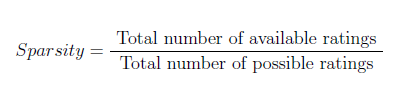

In [ ]:
num_user = len(users)
num_movie = len(movies)
print("Total number of users is", num_user)
print("Total number of movies is", num_movie)

Total number of users is 610
Total number of movies is 9724


In [ ]:
sparsity_data = 1 - len(ratings_data)/(num_user * num_movie)
print(sparsity_data)

0.9830003169443864


## QUESTION 2:

In [ ]:
len(np.unique(ratings_data['rating']))

10

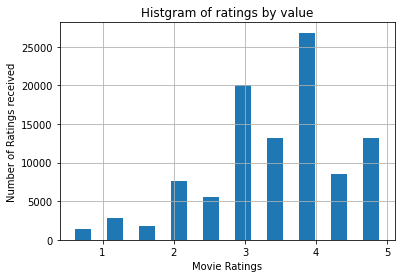

In [ ]:
plt.hist(ratings_data['rating'], bins= 10, rwidth= 0.5, align='mid')
plt.xlabel('Movie Ratings')
plt.ylabel("Number of Ratings received")
plt.title('Histgram of ratings by value')
plt.grid()

There are many users rating a movie for 3 and 4, and very few for rating 2 and below`

## QUESTION 3:

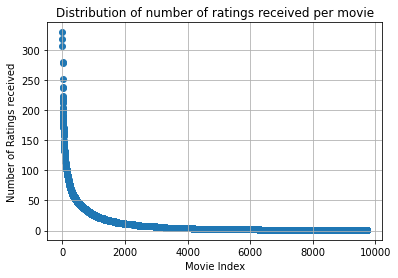

In [ ]:
rating_dist = [np.count_nonzero(ratings_data['movieId']==i) for i in movies]
# rating_dist_sorted = np.sort(rating_dist, key=rating_dist[:,1], reverse=True)
plt.scatter(range(len(movies)), np.sort(rating_dist)[::-1])
plt.xlabel('Movie Index')
plt.ylabel("Number of Ratings received")
plt.title('Distribution of number of ratings received per movie')
plt.grid()

In [ ]:
count = 0
for i in movies:
    if np.count_nonzero(ratings_data['movieId']==i) > 2:
        count=count+1
print(count)

4980


## QUESTION 4:

Text(0.5, 1.0, 'Distribution of number of ratings received per user')

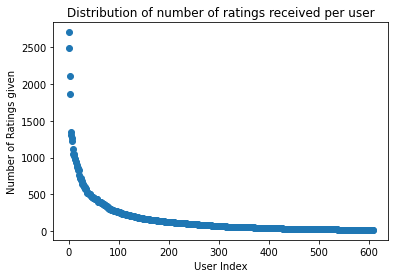

In [ ]:
user_dist = [np.count_nonzero(ratings_data['userId']==i) for i in users]
# rating_dist_sorted = np.sort(rating_dist, key=rating_dist[:,1], reverse=True)
plt.scatter(range(len(users)), np.sort(user_dist)[::-1])
plt.xlabel('User Index')
plt.ylabel("Number of Ratings given")
plt.title('Distribution of number of ratings received per user')

## QUESTION 5:
Most of the movies only recieved a few ratings.

## QUESTION 6:

In [ ]:
var_dist = []
for i in movies:
    var_dist.append(np.var(ratings_data['rating'][ratings_data['movieId'] == i]))

# movie_rating_var = np.var(ratings_data['rating'][ratings_data['movieId'] == i ])

Text(0.5, 1.0, 'Histgram of rating variance')

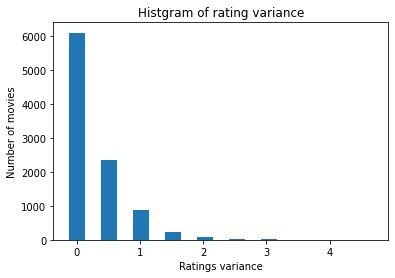

In [ ]:
plt.hist(var_dist, rwidth= 0.5, align='left')
plt.xlabel('Ratings variance')
plt.ylabel("Number of movies")
plt.title('Histgram of rating variance')

Most of the movies have rating variance less than 1, which means their ratings are very consistant among different users.

# Neighborhood-based collaborative filtering 

## QUESTION 7:
$ \mu_u =\frac {\sum_{k \in I_u} r_{uk}}{|I_u|} $ 


## QUESTION 8:

The common set of indices of movies that both user u and v have rated.

It can be empty, because there can exist two users who don't rate any same movies 

## QUESTION 9:

## QUESTION 10: k-NN collaborative filter
The functions that might be useful for solving question 10 are described in the documentation below:

http://surprise.readthedocs.io/en/stable/knn_inspired.html

http://surprise.readthedocs.io/en/stable/model_selection.html##surprise.model_selection.validation.cross_validate

For question 10, use Pearson-correlation function as the similarity metric. You can read about how to specify the similarity metric in the documentation below:
http://surprise.readthedocs.io/en/stable/similarities.html

In [ ]:
from surprise import KNNBasic
from surprise import Dataset
from surprise import accuracy
from surprise import Reader

# Load the movielens dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_data.iloc[:, :3], reader)

# define a cross-validation iterator
kf = KFold(n_splits=10)

In [ ]:
%%time
average_RMSE =[]
average_MAE =[]

k_range = range(2, 101, 2)
sim_option = {'name': 'pearson_baseline',
               'shrinkage': 0  # no shrinkage
               }

for k in k_range:
    model_knn = KNNBasic(k=k, sim_options = sim_option)
    rmse = 0
    mae = 0
    for trainset, testset in kf.split(data):
        
        # train and test algorithm.
        model_knn.fit(trainset)
        predictions = model_knn.test(testset)
        
        # Compute and print Root Mean Squared Error and MAE
        rmse += accuracy.rmse(predictions, verbose=False)
        mae += accuracy.mae(predictions, verbose=False)
        
    average_RMSE.append(rmse/10)
    average_MAE.append(mae/10)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Text(0.5, 1.0, 'average RMSE vs k')

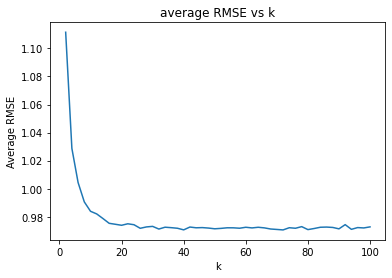

In [ ]:
plt.plot(k_range, average_RMSE)
plt.xlabel('k')
plt.ylabel('Average RMSE')
plt.title('average RMSE vs k')

Text(0.5, 1.0, 'average MAE vs k')

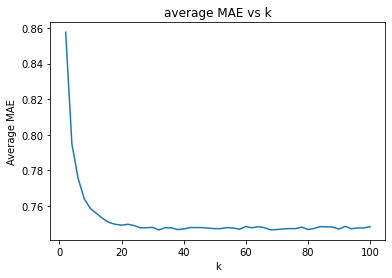

In [ ]:
plt.plot(k_range, average_MAE)
plt.xlabel('k')
plt.ylabel('Average MAE')
plt.title('average MAE vs k')

## QUESTION 11:

From Graph, minimum k = 20

In [ ]:
model_best_knn = KNNBasic(k=20, sim_options = sim_option)
rmse = 0
mae = 0
for trainset, testset in kf.split(data):
    # train and test algorithm.
    model_knn.fit(trainset)
    predictions = model_knn.test(testset)
        
    # Compute and print Root Mean Squared Error and MAE
    rmse += accuracy.rmse(predictions, verbose=False)
    mae += accuracy.mae(predictions, verbose=False)
        
average_RMSE_best_k = rmse/10
average_MAE_best_k = mae/10
print("Best RMSE is", average_RMSE_best_k)
print("Best MAE is", average_MAE_best_k)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

## QUESTION 12: popular movie test

In [ ]:
def popular_trim(data):
    # data is a list of tuples (uid, mid, rating)
    freq = {}
    ind = []
    for (uid, mid, rating) in data:
        if (mid in freq):
            freq[mid] += 1
        else:
            freq[mid] = 1
        # print(data)
    for i, entry in enumerate(data):
        if freq[entry[1]] <= 2:
            ind.append(i)
    for i in sorted(ind, reverse=True):
        del data[i] 
    return data
def unpopular_trim(data):
    freq = {}
    ind = []
    for (uid, mid, rating) in data:
        if (mid in freq):
            freq[mid] += 1
        else:
            freq[mid] = 1
    for i, entry in enumerate(data):
        if freq[entry[1]] > 2:
            ind.append(i)
        # if entry[1] not in freq:
        #     data.remove(entry)
    for i in sorted(ind, reverse=True):
        del data[i] 
    return data
def high_var_trim(data):
    arr = np.array(data)
    mids = np.unique(arr[:, 1])
    movie_var = []
    ind = []
    for i in mids:
        movie_var.append(np.var(arr[:, 2][arr[:,1]==i]))
    freq = {} # dict to store mid and their number of appearance
    trim_ind = np.array(movie_var) < 2
    for (uid, mid, rating) in data:
        if (mid in freq):
            freq[mid] += 1
        else:
            freq[mid] = 1
        
    for i, entry in enumerate(data):
        if freq[entry[1]] < 5 or entry[1] in mids[trim_ind]:
            ind.append(i)
    for i in sorted(ind, reverse=True):
        del data[i]
    return data

In [ ]:
%%time
average_RMSE =[]
average_MAE =[]

k_range = range(2, 101, 2)
sim_option = {'name': 'pearson_baseline',
               'shrinkage': 0  # no shrinkage
               }

for k in k_range:
    model_knn = KNNBasic(k=k, sim_options = sim_option)
    rmse = 0
    mae = 0
    for trainset, testset in kf.split(data):
        
        # Popular trim test set
        testset = popular_trim(testset)
        
        # train and test algorithm.
        model_knn.fit(trainset)
        predictions = model_knn.test(testset)
        
        # Compute and print Root Mean Squared Error and MAE
        rmse += accuracy.rmse(predictions, verbose=False)
        mae += accuracy.mae(predictions, verbose=False)
        
    average_RMSE.append(rmse/10)
    average_MAE.append(mae/10)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Text(0.5, 1.0, 'Popular Trim average RMSE vs k')

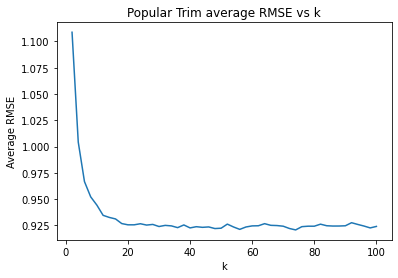

In [ ]:
plt.plot(k_range, average_RMSE)
plt.xlabel('k')
plt.ylabel('Average RMSE')
plt.title('Popular Trim average RMSE vs k')

In [ ]:
print('The minimum average RMSE is',min(average_RMSE))

The minimum average RMSE is 0.9205711927601286


## QUESTION 13: unpopular movie test

In [ ]:
%%time
average_RMSE =[]
average_MAE =[]

k_range = range(2, 101, 2)
sim_option = {'name': 'pearson_baseline',
               'shrinkage': 0  # no shrinkage
               }

for k in k_range:
    model_knn = KNNBasic(k=k, sim_options = sim_option)
    rmse = 0
    mae = 0
    for trainset, testset in kf.split(data):
        
        # Popular trim test set
        testset = unpopular_trim(testset)
        
        # train and test algorithm.
        model_knn.fit(trainset)
        predictions = model_knn.test(testset)
        
        # Compute and print Root Mean Squared Error and MAE
        rmse += accuracy.rmse(predictions, verbose=False)
        mae += accuracy.mae(predictions, verbose=False)
        
    average_RMSE.append(rmse/10)
    average_MAE.append(mae/10)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Text(0.5, 1.0, 'Unpopular Trim average RMSE vs k')

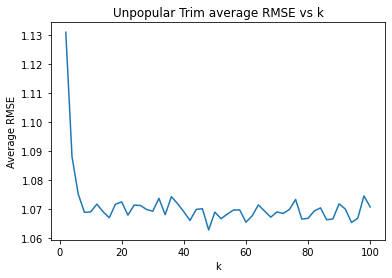

In [ ]:
plt.plot(k_range, average_RMSE)
plt.xlabel('k')
plt.ylabel('Average RMSE')
plt.title('Unpopular Trim average RMSE vs k')

In [ ]:
print('The minimum average RMSE is',min(average_RMSE))

The minimum average RMSE is 1.0629058137681555


## QUESTION 14: high variance movie test

In [ ]:
%%time
average_RMSE =[]
average_MAE =[]

k_range = range(2, 101, 2)
sim_option = {'name': 'pearson_baseline',
               'shrinkage': 0  # no shrinkage
               }

for k in k_range:
    model_knn = KNNBasic(k=k, sim_options = sim_option)
    rmse = 0
    mae = 0
    for trainset, testset in kf.split(data):
        
        # Popular trim test set
        testset = high_var_trim(testset)
        
        # train and test algorithm.
        model_knn.fit(trainset)
        predictions = model_knn.test(testset)
        
        # Compute and print Root Mean Squared Error and MAE
        rmse += accuracy.rmse(predictions, verbose=False)
        mae += accuracy.mae(predictions, verbose=False)
        
    average_RMSE.append(rmse/10)
    average_MAE.append(mae/10)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

Text(0.5, 1.0, 'High Var Trim average RMSE vs k')

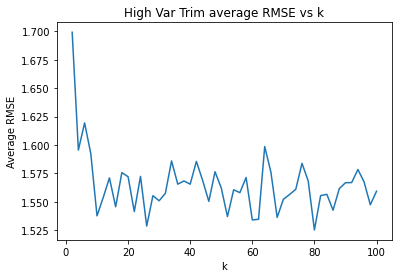

In [ ]:
plt.plot(k_range, average_RMSE)
plt.xlabel('k')
plt.ylabel('Average RMSE')
plt.title('High Var Trim average RMSE vs k')

In [ ]:
print('The minimum average RMSE is',min(average_RMSE))

The minimum average RMSE is 1.525231033876935


## QUESTION 15: Plot the ROC curves for the k-NN collaborative filter

In [ ]:
thresholds = [2.5, 3, 3.5, 4]
fprs = []
tprs = []
for threshold in thresholds:
    for trainset, testset in kf.split(data):
        model_best_knn.fit(trainset)
        y_pred = model_best_knn.test(testset)
        y_pred_ratings = []
        for pred in y_pred:
            y_pred_ratings.append(pred.est)
        y_pred_ratings = np.array(y_pred_ratings)
        
        #### convert the observed ratings to a binary scale.
        y_test = []
        for entry in testset:
            if entry[2]  > threshold:
                rating = 1
            else:
                rating = 0
            y_test.append(rating)
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_ratings)
        break
    fprs.append(fpr)
    tprs.append(tpr)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


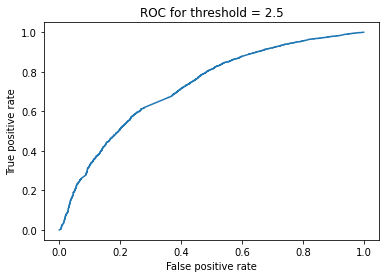

AUC is 0.7260850182938754


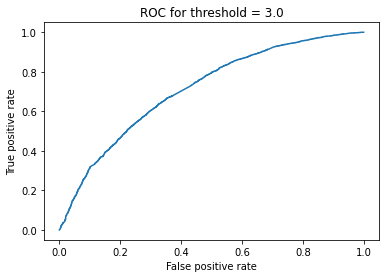

AUC is 0.7122399358278614


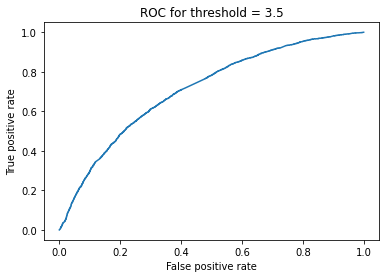

AUC is 0.7098264496408173


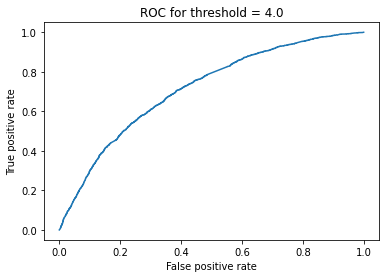

AUC is 0.7139398030123537


In [ ]:
for i, threshold in enumerate(thresholds):
    plt.plot(fprs[i], tprs[i])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title("ROC for threshold = %1.1f" %threshold)
    plt.show()
    print('AUC is', auc(fprs[i], tprs[i]))

# Model-based collaborative filtering 

## QUESTION 16:

## QUESTION 17: Design a NNMF-based collaborative filter
For solving question 17, the functions described in the documentation below might be useful

http://surprise.readthedocs.io/en/stable/matrix_factorization.html

In [ ]:
#var_list = list(ratings_data[['movieId','rating']].groupby('movieId').var()['rating'])

#def get_popular(rating_dist, testset):
 #   movieids = [x[0] for x in rating_dist.items() if x[1]>2]
  #  return [x for x in testset if x[1] in movieids]

#def get_unpopular(rating_dist, testset):
 #   movieids = [x[0] for x in rating_dist.items() if x[1]<=2]
  #  return [x for x in testset if x[1] in movieids]

var_dist = []
for i in movies:
    var_dist.append(np.var(ratings_data['rating'][ratings_data['movieId'] == i]))

def NMF_filter(data_, range_,trimm, rating_dist,splits=10, var_dist=None):
    kf = KFold(n_splits=splits)
    reader = Reader(rating_scale=(0.5, 5))
    mae_d={}
    rmse_d={}
    for latent_factors in range_:
        print('Number of Latent Factors : ',latent_factors)
        nmf_model = NMF(n_factors = latent_factors,random_state=42)
        rmse_list=[]
        mae_list =[]
        for trainset, testset in kf.split(data_):
            #print(testset)
            if(trimm=='p'):
                testset = popular_trim(testset) # made modifications
            elif(trimm=='up'):
                testset = unpopular_trim(testset) # made modifications
            elif(trimm=='hv'):
                testset = high_var_trim(testset)
            nmf_model.fit(trainset)
            predictions = nmf_model.test(testset,verbose=False)
            rmse_list.append(accuracy.rmse(predictions,verbose=False))
            mae_list.append(accuracy.mae(predictions,verbose=False))
        rmse_d[latent_factors]=sum(rmse_list)/len(rmse_list)
        mae_d[latent_factors]=sum(mae_list)/len(mae_list)
        print('Mean rmse',sum(rmse_list)/len(rmse_list))
        print('Mean mae',sum(mae_list)/len(mae_list))
    return rmse_d, mae_d

In [ ]:
from surprise.prediction_algorithms.matrix_factorization import NMF,SVD
reader = Reader(rating_scale=(0.5, 5))
total_data = Dataset.load_from_df(ratings_data[['userId','movieId','rating']], reader)
nmf_rmse , nmf_mae = NMF_filter(total_data, range(2,51,2),'notrim',rating_dist) #replace 8 with 2

Number of Latent Factors :  2
Mean rmse 1.1466016118917683
Mean mae 0.9628638417887672
Number of Latent Factors :  4
Mean rmse 1.0414066564078335
Mean mae 0.8509696089404513
Number of Latent Factors :  6
Mean rmse 0.9834482871874284
Mean mae 0.7866359570733856
Number of Latent Factors :  8
Mean rmse 0.949788031056301
Mean mae 0.7485305749946984
Number of Latent Factors :  10
Mean rmse 0.9343756288737322
Mean mae 0.7292021772540649
Number of Latent Factors :  12
Mean rmse 0.9211948594243857
Mean mae 0.7117945608289425
Number of Latent Factors :  14
Mean rmse 0.9142087411629436
Mean mae 0.7012587240976286
Number of Latent Factors :  16
Mean rmse 0.913915959271384
Mean mae 0.6985342154100194
Number of Latent Factors :  18
Mean rmse 0.9144633473703111
Mean mae 0.6962503083493278
Number of Latent Factors :  20
Mean rmse 0.9157770748009761
Mean mae 0.6954721534320824
Number of Latent Factors :  22
Mean rmse 0.916455605338016
Mean mae 0.6935133926308926
Number of Latent Factors :  24
Mean rms

In [ ]:
def rmse_mae_plot(rmse_d,mae_d,xl):
    plt.plot(list(rmse_d.keys()),list(rmse_d.values()))
    plt.xlabel(xl)
    plt.ylabel('Average RMSE')
    plt.title(xl+ ' Vs Average RMSE')
    plt.show()
    
    plt.plot(list(mae_d.keys()),list(mae_d.values()))
    plt.xlabel(xl)
    plt.ylabel('Average MAE')
    plt.title(xl+' Vs Average MAE')
    plt.show()

rmse_mae_plot(nmf_rmse,nmf_mae,'Amount of Latent Factors')

## QUESTION 18:

In [ ]:
print("Minimum Average RMSE : ",min(nmf_rmse.values()))
print("Minimum Average MAE : ",min(nmf_mae.values()))
best_n_factors = [k for k,v in nmf_rmse.items() if v == min(nmf_rmse.values())]
best_n_factors_nmf = best_n_factors[0]
print("Best number of latent factors : ",best_n_factors_nmf)

## QUESTION 19:

In [ ]:
print("-----Popular Movies Testset-----")
nmf_rmse_p , nmf_mae_p = NMF_filter(total_data, range(2,51,2),'p',rating_dist) #replace 8 with 2

## QUESTION 20:

In [ ]:
print("-----Unpopular Movies Testset-----")
nmf_rmse_up , nmf_mae_up = NMF_filter(total_data, range(2,51,2),'up',rating_dist) #replace 8 with 2

## QUESTION 21:

In [ ]:
var_dist = []
for i in movies:
    var_dist.append(np.var(ratings_data['rating'][ratings_data['movieId'] == i]))

print("-----High Variance Movies Testset-----")
nmf_rmse_hv , nmf_mae_hv = NMF_filter(total_data, range(2,51,2),'hv',rating_dist) 

In [ ]:
print("-----Popular Movies Testset-----")
rmse_mae_plot(nmf_rmse_p,nmf_mae_p,'Number of Latent Factors')
print("Minimum Average RMSE : ",min(nmf_rmse_p.values()))
print("Minimum Average MAE : ",min(nmf_mae_p.values()))
print("-----Unpopular Movies Testset-----")
rmse_mae_plot(nmf_rmse_up,nmf_mae_up,'Number of Latent Factors')
print("Minimum Average RMSE : ",min(nmf_rmse_up.values()))
print("Minimum Average MAE : ",min(nmf_mae_up.values()))
print("-----High Variance Movies Testset-----")
rmse_mae_plot(nmf_rmse_hv,nmf_mae_hv,'Number of Latent Factors')
print("Minimum Average RMSE : ",min(nmf_rmse_hv.values()))
print("Minimum Average MAE : ",min(nmf_mae_hv.values()))

## QUESTION 22: Plot the ROC curves for the NNMF-based collaborative

In [ ]:
thresholds = [2.5, 3, 3.5, 4]
fprs = []
tprs = []
roc_nmf_model = NMF(n_factors = best_n_factors_nmf,random_state=42)
for threshold in thresholds:
    for trainset, testset in kf.split(data):
        roc_nmf_model.fit(trainset)
        y_pred = roc_nmf_model.test(testset)
        y_pred_ratings = []
        for pred in y_pred:
            y_pred_ratings.append(pred.est)
        y_pred_ratings = np.array(y_pred_ratings)
        
        #### convert the observed ratings to a binary scale.
        y_test = []
        for entry in testset:
            if entry[2]  > threshold:
                rating = 1
            else:
                rating = 0
            y_test.append(rating)
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_ratings)
        break
    fprs.append(fpr)
    tprs.append(tpr)

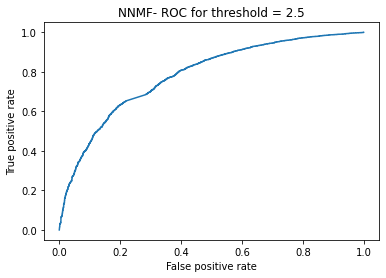

AUC is 0.7837737117797541


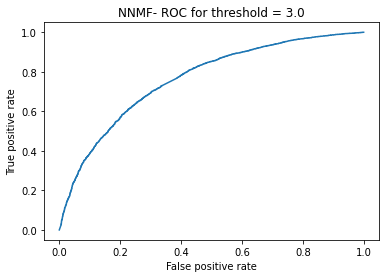

AUC is 0.7628723760864953


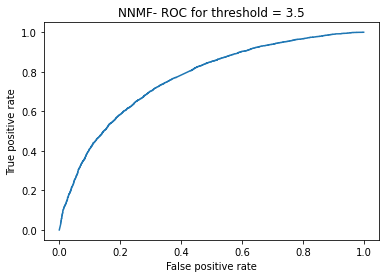

AUC is 0.7681021643688046


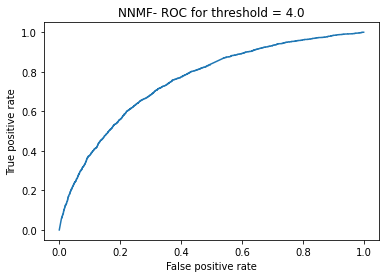

AUC is 0.7563995307542374


In [ ]:
for i, threshold in enumerate(thresholds):
    plt.plot(fprs[i], tprs[i])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title("NNMF- ROC for threshold = %1.1f" %threshold)
    plt.show()
    print('AUC is', auc(fprs[i], tprs[i]))

## QUESTION 23:

In [ ]:
algo = NMF(n_factors = 20, random_state=42)
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_data[['userId','movieId','rating']], reader)
trainset = data.build_full_trainset()
algo.fit(trainset)
v = algo.qi
top_ids = [[] for _ in range(20)]
for i in range(0,v.shape[1]):
    top_ids[i].append(np.argsort(v[:,i]))

In [ ]:
arr = ratings_data['movieId'].values
indexes = np.unique(arr,return_index = True)[1]
movie_list = [arr[i] for i in sorted(indexes)]

In [ ]:
d2l.DATA_HUB['ml-latest-small'] = (
    'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip',
    '31a303aabbc519bd33d025e44d6c2570'
)
data_dir = d2l.download_extract('ml-latest-small')
# names = ['userId', 'item_id', 'rating', 'timestamp']
movies_data = pd.read_csv(os.path.join(data_dir, 'movies.csv'), ',', engine='python')

In [ ]:
movies_data

In [ ]:
#movies_data = pd.read_csv('movies.csv')
movie_genre = movies_data[['movieId','genres']]

In [ ]:
for col_num in range(0,5):
    print("Genres for column ",col_num," : ")
    top10 = []
    genres = []
    movies_true_ids = []
    a = top_ids[col_num]
    for i in range(0,10):
        top10.append(a[0][i])
        movies_true_ids.append(movie_list[top10[i]])
        genres.append(list(movie_genre.iloc[movie_genre.index[movie_genre['movieId'] == movies_true_ids[i]]]['genres'].values))
    print(genres)

Genres for column  0  : 
[['Action|Drama|Fantasy'], ['Drama|War'], ['Animation|Children|Comedy'], ['Action|Fantasy|Sci-Fi|IMAX'], ['Drama'], ['Fantasy|Horror'], ['Comedy|Romance'], ['Comedy'], ['Comedy'], ['Comedy']]
Genres for column  1  : 
[['Comedy|Drama'], ['Comedy|Romance'], ['Drama|Musical|Mystery'], ['Children|Comedy'], ['Action|Sci-Fi'], ['Comedy'], ['Comedy'], ['Adventure|Animation|Children|Comedy'], ['Horror'], ['Comedy|Fantasy']]
Genres for column  2  : 
[['Animation|Children|Comedy|Musical'], ['Children|Comedy'], ['Animation|Comedy|Fantasy'], ['Children|Comedy'], ['Comedy|Drama|Romance'], ['Comedy'], ['Comedy'], ['Comedy|Romance'], ['Horror'], ['Drama|Thriller']]
Genres for column  3  : 
[['Thriller'], ['Drama|Mystery'], ['Action|Comedy|Western'], ['Action|Comedy|Crime'], ['Comedy'], ['Comedy'], ['Comedy|Drama|Romance'], ['Drama'], ['Children|Comedy'], ['Comedy|Musical']]
Genres for column  4  : 
[['Fantasy|Horror'], ['Comedy|Documentary|Drama|Romance'], ['Adventure|Childre

In [ ]:
for col_num in range(0,5):
    print("Genres for column ",col_num," : ")
    top10 = []
    genres = []
    movies_true_ids = []
    a = top_ids[col_num]
    for i in range(0,10):
        top10.append(a[0][i])
        movies_true_ids.append(movie_list[top10[i]])
        genres.append(list(movie_genre.iloc[movie_genre.index[movie_genre['movieId'] == movies_true_ids[i]]]['genres'].values))
    print(genres)

Genres for column  0  : 
[['Action|Drama|Fantasy'], ['Drama|War'], ['Animation|Children|Comedy'], ['Action|Fantasy|Sci-Fi|IMAX'], ['Drama'], ['Fantasy|Horror'], ['Comedy|Romance'], ['Comedy'], ['Comedy'], ['Comedy']]
Genres for column  1  : 
[['Comedy|Drama'], ['Comedy|Romance'], ['Drama|Musical|Mystery'], ['Children|Comedy'], ['Action|Sci-Fi'], ['Comedy'], ['Comedy'], ['Adventure|Animation|Children|Comedy'], ['Horror'], ['Comedy|Fantasy']]
Genres for column  2  : 
[['Animation|Children|Comedy|Musical'], ['Children|Comedy'], ['Animation|Comedy|Fantasy'], ['Children|Comedy'], ['Comedy|Drama|Romance'], ['Comedy'], ['Comedy'], ['Comedy|Romance'], ['Horror'], ['Drama|Thriller']]
Genres for column  3  : 
[['Thriller'], ['Drama|Mystery'], ['Action|Comedy|Western'], ['Action|Comedy|Crime'], ['Comedy'], ['Comedy'], ['Comedy|Drama|Romance'], ['Drama'], ['Children|Comedy'], ['Comedy|Musical']]
Genres for column  4  : 
[['Fantasy|Horror'], ['Comedy|Documentary|Drama|Romance'], ['Adventure|Childre

In [ ]:
import pandas as pd
import numpy as np

genre_data = {'genre0': ['Action|Drama|Fantasy', 'Drama|War', 'Animation|Children|Comedy', 'Action|Fantasy|Sci-Fi|IMAX', 'Drama', 'Fantasy|Horror', 'Comedy|Romance', 'Comedy', 'Comedy', 'Comedy'], 'genre1': ['Comedy|Drama', 'Comedy|Romance', 'Drama|Musical|Mystery', 'Children|Comedy', 'Action|Sci-Fi', 'Comedy', 'Comedy', 'Adventure|Animation|Children|Comedy', 'Horror', 'Comedy|Fantasy'], 'genre2': ['Animation|Children|Comedy|Musical', 'Children|Comedy', 'Animation|Comedy|Fantasy', 'Children|Comedy', 'Comedy|Drama|Romance', 'Comedy', 'Comedy', 'Comedy|Romance', 'Horror', 'Drama|Thriller'], 'genre3':['Thriller', 'Drama|Mystery', 'Action|Comedy|Western', 'Action|Comedy|Crime', 'Comedy', 'Comedy', 'Comedy|Drama|Romance', 'Drama', 'Children|Comedy', 'Comedy|Musical'],'genre4':['Fantasy|Horror', 'Comedy|Documentary|Drama|Romance', 'Adventure|Children|Comedy', 'Thriller', 'Crime|Horror|Thriller', 'Animation|Children|Comedy', 'Children|Comedy', 'Fantasy|Horror|Thriller', 'Horror|Mystery|Thriller', 'Animation|Children|Comedy|Musical']}
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
df = pd.DataFrame(genre_data , index=labels)
print("Select specific columns:")
print(df[['genre0', 'genre1']] + "\n")
print('\n')
print(df[['genre2', 'genre3']])
print('\n')
print(df[['genre4']])




Select specific columns:
                         genre0                                 genre1
a        Action|Drama|Fantasy\n                         Comedy|Drama\n
b                   Drama|War\n                       Comedy|Romance\n
c   Animation|Children|Comedy\n                Drama|Musical|Mystery\n
d  Action|Fantasy|Sci-Fi|IMAX\n                      Children|Comedy\n
e                       Drama\n                        Action|Sci-Fi\n
f              Fantasy|Horror\n                               Comedy\n
g              Comedy|Romance\n                               Comedy\n
h                      Comedy\n  Adventure|Animation|Children|Comedy\n
i                      Comedy\n                               Horror\n
j                      Comedy\n                       Comedy|Fantasy\n


                              genre2                 genre3
a  Animation|Children|Comedy|Musical               Thriller
b                    Children|Comedy          Drama|Mystery
c           

In [ ]:
def SVD_filter(data_, range_,trimm,rating_dist,splits=10, var_dist=None):
    kf = KFold(n_splits=splits)
    reader = Reader(rating_scale=(0.5, 5))
    mae_d={}
    rmse_d={}
    for latent_factors in range_:
        print('Number of Latent Factors : ',latent_factors)
        svd_model = SVD(n_factors = latent_factors,random_state=42)
        rmse_list=[]
        mae_list =[]
        for trainset, testset in kf.split(data_):
            #print(testset)
            if(trimm=='p'):
                testset = popular_trim(testset)
            elif(trimm=='up'):
                testset = unpopular_trim(testset)
            elif(trimm=='hv'):
                testset = high_var_trim(testset)
            svd_model.fit(trainset)
            predictions = svd_model.test(testset,verbose=False)
            rmse_list.append(accuracy.rmse(predictions,verbose=False))
            mae_list.append(accuracy.mae(predictions,verbose=False))
        rmse_d[latent_factors]=sum(rmse_list)/len(rmse_list)
        mae_d[latent_factors]=sum(mae_list)/len(mae_list)
        print('Mean rmse',sum(rmse_list)/len(rmse_list))
        print('Mean mae',sum(mae_list)/len(mae_list))
    return rmse_d, mae_d

## QUESTION 24: Design a MF with bias collaborative filter

In [ ]:
total_data = Dataset.load_from_df(ratings_data[['userId','movieId','rating']], reader)
svd_rmse , svd_mae = SVD_filter(total_data, range(2,51,2),'notrim',ratings_data)

In [ ]:
rmse_mae_plot(svd_rmse,svd_mae,'Number of Latent Factors')

## QUESTION 25:

In [ ]:
print("Minimum Average RMSE : ",min(svd_rmse.values()))
print("Minimum Average MAE : ",min(svd_mae.values()))
best_n_factors = [k for k,v in svd_rmse.items() if v == min(svd_rmse.values())]
best_n_factors_svd = best_n_factors[0]
print("Best number of latent factors : ",best_n_factors_svd)

## QUESTION 26:

In [ ]:
print("-----Popular Movies Testset-----")
svd_rmse_p , svd_mae_p = SVD_filter(total_data, range(2,51,2),'p',rating_dist)

## QUESTION 27:

In [ ]:
print("-----Unpopular Movies Testset-----")
svd_rmse_up , svd_mae_up = SVD_filter(total_data, range(2,51,2),'up',rating_dist)

## QUESTION 28:

In [ ]:
print("-----High Variance Movies Testset-----")
svd_rmse_hv , svd_mae_hv = SVD_filter(total_data, range(2,51,2),'hv',rating_dist)

In [ ]:
print("-----Popular Movies Testset-----")
rmse_mae_plot(svd_rmse_p , svd_mae_p,'Number of Latent Factors')
print("Minimum Average RMSE : ",min(svd_rmse_p.values()))
print("Minimum Average MAE : ",min(svd_mae_p.values()))
print("-----Unpopular Movies Testset-----")
rmse_mae_plot(svd_rmse_up , svd_mae_up,'Number of Latent Factors')
print("Minimum Average RMSE : ",min(svd_rmse_up.values()))
print("Minimum Average MAE : ",min(svd_mae_up.values()))
print("-----High Variance Movies Testset-----")
rmse_mae_plot(svd_rmse_hv,svd_mae_hv,'Number of Latent Factors')
print("Minimum Average RMSE : ",min(svd_rmse_hv.values()))
print("Minimum Average MAE : ",min(svd_mae_hv.values()))

## QUESTION 29:

In [ ]:
# data_ROC = Dataset.load_from_df(ratings_data[['userId','movieId','rating']], reader)
# train_set, test_set = train_test_split(data_roc, test_size = 0.1, random_state = 42)
# roc_svd_model = SVD(n_factors = best_n_factors_svd,random_state=42)
# roc_svd_model.fit(train_set)
# preds = roc_svd_model.test(test_set)
# thresholds = [2.5,3,3.5,4]
# plot_roc_curves(test_set,preds,thresholds)

In [ ]:
thresholds = [2.5, 3, 3.5, 4]
fprs = []
tprs = []
roc_svd_model = SVD(n_factors = 44,random_state=42)
for threshold in thresholds:
    for trainset, testset in kf.split(data):
        roc_svd_model.fit(trainset)
        y_pred = roc_svd_model.test(testset)
        y_pred_ratings = []
        for pred in y_pred:
            y_pred_ratings.append(pred.est)
        y_pred_ratings = np.array(y_pred_ratings)
        
        #### convert the observed ratings to a binary scale.
        y_test = []
        for entry in testset:
            if entry[2]  > threshold:
                rating = 1
            else:
                rating = 0
            y_test.append(rating)
        
        fpr, tpr, _ = roc_curve(y_test, y_pred_ratings)
        break
    fprs.append(fpr)
    tprs.append(tpr)

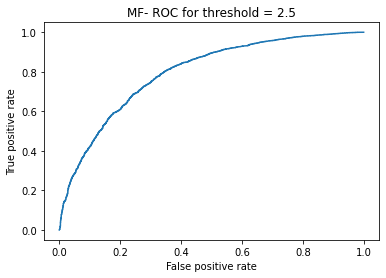

AUC is 0.7959471384560497


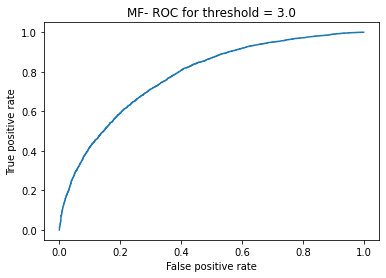

AUC is 0.7794001717230865


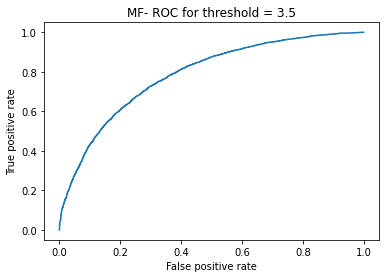

AUC is 0.7846496925009661


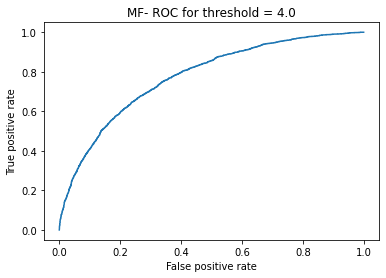

AUC is 0.7755929873006784


In [ ]:
for i, threshold in enumerate(thresholds):
    plt.plot(fprs[i], tprs[i])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title("MF- ROC for threshold = %1.1f" %threshold)
    plt.show()
    print('AUC is', auc(fprs[i], tprs[i]))

# Naive collaborative filtering

## QUESTION 30: Design a naive collaborative filter

In [ ]:
#reprocess data
customized_reader = Reader(line_format='user item rating', sep=',',skip_lines=1, rating_scale=(0.5, 5.0))
file_path = os.path.join(data_dir, 'ratings.csv')
data = Dataset.load_from_file(file_path, reader= customized_reader)
from sklearn.metrics import mean_squared_error

In [ ]:
reference = {}
for i in data.raw_ratings:
    if i[0] in reference.keys():
        reference[i[0]].append(i[2])
    else:
        reference[i[0]] = []
        reference[i[0]].append(i[2])
validation_folds = 10
user = {}
for i in reference.keys():
    user[i] = np.mean(reference[i])

rmse = 0
for train, test in kf.split(data):
    pred = [user[k[0]] for k in test]
    true = [k[2] for k in test]
    rmse = rmse + np.sqrt(mean_squared_error(true,pred))
average_rmse = rmse/validation_folds

print("Average RMSE ", average_rmse)


## QUESTION 31:

In [ ]:
#popular movie trimmed set 

reference = {}
for i in data.raw_ratings:
    if i[0] in reference.keys():
        reference[i[0]].append(i[2])
    else:
        reference[i[0]] = []
        reference[i[0]].append(i[2])

user = {}
for i in reference.keys():
    user[i] = np.mean(reference[i])
#previous definition of trim wont be iterable for this data object 
reference_trim = {}
for i in data.raw_ratings:
    if i[1] in reference_trim.keys():
        reference_trim[i[1]].append(i[2])
    else:
        reference_trim[i[1]] = []
        reference_trim[i[1]].append(i[2])
validation_folds = 10
rmse = 0
for train, test in kf.split(data):
    trim = [i for i in test if len(reference_trim[i[1]])> 2]
    pred = [user[k[0]] for k in trim]
    true = [k[2] for k in trim]
    rmse = rmse + np.sqrt(mean_squared_error(true,pred))
average_rmse = rmse/validation_folds

print("Average RMSE ", average_rmse)

## QUESTION 32:

In [ ]:
#unpopular movie trimmed set 

reference = {}
for i in data.raw_ratings:
    if i[0] in reference.keys():
        reference[i[0]].append(i[2])
    else:
        reference[i[0]] = []
        reference[i[0]].append(i[2])

user = {}
for i in reference.keys():
    user[i] = np.mean(reference[i])
#previous definition of trim wont be iterable for this data object 
reference_trim = {}
for i in data.raw_ratings:
    if i[1] in reference_trim.keys():
        reference_trim[i[1]].append(i[2])
    else:
        reference_trim[i[1]] = []
        reference_trim[i[1]].append(i[2])
validation_folds = 10
rmse = 0
for train, test in kf.split(data):
    trim = [i for i in test if len(reference_trim[i[1]]) <= 2]
    pred = [user[k[0]] for k in trim]
    true = [k[2] for k in trim]
    rmse = rmse + np.sqrt(mean_squared_error(true,pred))
average_rmse = rmse/validation_folds

print("Average RMSE ", average_rmse)

## QUESTION 33:

In [ ]:
# high variance movie trimmed set 

reference = {}
for i in data.raw_ratings:
    if i[0] in reference.keys():
        reference[i[0]].append(i[2])
    else:
        reference[i[0]] = []
        reference[i[0]].append(i[2])
        
user = {}
for i in reference.keys():
    user[i] = np.mean(reference[i])
#previous definition of trim wont be iterable for this data object 
reference_trim = {}
for i in data.raw_ratings:
    if i[1] in reference_trim.keys():
        reference_trim[i[1]].append(i[2])
    else:
        reference_trim[i[1]] = []
        reference_trim[i[1]].append(i[2])
validation_folds = 10
rmse = 0
for train, test in kf.split(data):
    trim = [i for i in test if np.var(reference_trim[i[1]])>=2 and len(reference_trim[i[1]]) >=5]
    pred = [user[k[0]] for k in trim]
    true = [k[2] for k in trim]
    rmse = rmse + np.sqrt(mean_squared_error(true,pred))
average_rmse = rmse/validation_folds

print("Average RMSE ", average_rmse)

# Performance comparison and Ranking 

## QUESTION 34: Plot the ROC curves (threshold = 3) for the k-NN, NNMF, and MF

In [ ]:
threshold = 3 
models = [KNNBasic(k=20, sim_options = {'name':'pearson'}), NMF(n_factors = 16,random_state=42), SVD(n_factors = 26,random_state=42)]

model_fpr,model_tpr,model_auc = [],[],[]
for model in models:
    print('Algorithm is ', model)
    for trainset, testset in kf.split(data):
        model.fit(trainset)
        predictions = model.test(testset)
        pred_est = np.array([i.est for i in predictions])
        ratings = np.array([i.r_ui for i in predictions])
        y_score = pred_est
        y_true = ratings >= threshold
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        model_fpr.append(fpr)
        model_tpr.append(tpr)
        model_auc.append(roc_auc)


In [ ]:
plt.figure(figsize = (10,8))
plt.xlabel('False Positive') #frontsize =20
plt.ylabel('True Positive')
plt.plot([0, 1], [0, 1], color='green', linestyle='-.')
plt.xlim([0.0, 1.02])
plt.ylim([0.0, 1.05])
plt.title("ROC Curves Comparison (Threshold=3)")

#knn plot
plt.plot(model_fpr[0], model_tpr[0], color='green', lw=1, label='KNN' % model_auc[0]) #lw=1.5
#nnmf plot
plt.plot(model_fpr[1], model_tpr[1], color='blue', lw=1, label='NNMF' % model_auc[1])
#mf plot
plt.plot(model_fpr[2], model_tpr[2], color='red', lw=1, label='MF' % model_auc[2])

plt.legend()
plt.show()

## QUESTION 35:

## QUESTION 36:

In [ ]:
from collections import defaultdict, Counter
def plot_P_R(y,x,y_label,x_label,title):
    plt.figure()
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(x,y, color='red', lw=1)
    plt.show()

#get predictions first, then do ranking of such 
def precision_recall_at_t(predictions, t, threshold=3): 
    #use threshold = 3, for obtaining the set G  
    '''Return precision and recall at k metrics for each user.'''
    
    user_est_true = defaultdict(list)
    for uid,_,u_ri,est,_ in predictions:
        user_est_true[uid].append((est, u_ri))
    
    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        # If |G| = 0 for some user in the test set, then drop this user
        # If some user in the test set has rated less than t items, then drop this user
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        n_actual = sum((r_ui >= threshold) for (_,r_ui) in user_ratings)
        
        n_rec_t = sum((est >= threshold) for (est, _) in user_ratings[:t])
        
        n_actual_and_rec_t = sum(((r_ui >= threshold) and (est >= threshold))
                              for (est, r_ui) in user_ratings[:t])

        precisions[uid] = n_actual_and_rec_t / n_rec_t if n_rec_t != 0 else 1
        recalls[uid] = n_actual_and_rec_t / n_actual if n_actual != 0 else 1
        
    return precisions, recalls

def Ranking_Precision_Recall(model,data,threshold=3):
    #Use 10-fold cross-validation to obtain the average precision and recall values for each value of t.
    kf = KFold(n_splits=10)
    averagePrecision_over_t = []
    averageRecall_over_t = []
    
    for t in range(1,26):
        averagePrecisions_eachFold = []
        averageRecalls_eachFold = []
        i=0
        for trainset, testset in kf.split(data):
            i+=1
            model.fit(trainset)
            predictions = model.test(testset)
            precisions, recalls = precision_recall_at_t(predictions, t=t, threshold=3)
        
            averagePrecisions_eachFold.append(sum(p for p in precisions.values())/float(len(precisions)))
            averageRecalls_eachFold.append(sum(r for r in recalls.values())/float(len(recalls)))
        averagePrecision_over_t.append(sum(averagePrecisions_eachFold)/float(len(averagePrecisions_eachFold)))
        averageRecall_over_t.append(sum(averageRecalls_eachFold)/float(len(averageRecalls_eachFold)))
    return averagePrecision_over_t, averageRecall_over_t


In [ ]:
precision_knn, recall_knn = Ranking_Precision_Recall(KNNBasic(k=20, sim_options= {'name':'pearson'}), data=data, threshold=3)

In [ ]:
plot_P_R(precision_knn,range(1,26),'Precision', 't', 'KNN Precision vs. t')
plot_P_R(recall_knn,range(1,26),'Recall', 't', 'KNN Recall vs. t')
plot_P_R(precision_knn, recall_knn, 'Precision','Recall','KNN Precision vs. Recall')

## QUESTION 37:

In [ ]:
precision_NNMF, recall_NNMF = Ranking_Precision_Recall(NMF(n_factors=18, random_state=42), data=data, threshold=3)

In [ ]:
plot_P_R(precision_NNMF,range(1,26),'Precision', 't', 'NNMF Precision vs. t')
plot_P_R(recall_NNMF,range(1,26),'Recall', 't', 'NNMF Recall vs. t')
plot_P_R(precision_NNMF,recall_NNMF, 'Precision','Recall','NNMF Precision vs. Recall')

## QUESTION 38:

In [ ]:
precision_MF, recall_MF = Ranking_Precision_Recall(SVD(n_factors=44, random_state=42), data=data, threshold=3)

In [ ]:
plot_P_R(precision_MF,range(1,26),'Precision', 't', 'MF Precision against t')
plot_P_R(recall_MF,range(1,26),'Recall', 't', 'MF Recall against t')
plot_P_R(precision_MF,recall_MF, 'Precision','Recall','MF Precision against Recall')

## QUESTION 39:

In [ ]:
plt.figure(figsize = (10,8))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.plot(recall_knn,precision_knn,color='green',lw=1,label='KNN')
plt.plot(recall_NNMF,precision_NNMF,color='blue',lw=1,label='NNMF')
plt.plot(recall_MF,precision_MF,color='red',lw=1,label='MF')
plt.legend()
plt.show()